In [138]:
## MVP
## start with node data frame
## create node depenency dataframe
## check if it is an accylic graph
## sort the nodes
## run the nodes
# capture errors and remove sub-tree where a node fails
## graph the nodes

## extras
# parralel running
# group trees

In [43]:
import numpy as np
import pandas as pd
import networkx as nx
import subprocess

# read in the nodes and depenencies
schedule_data = {"process" : [
                "extract_2",
                "extract_3",
                "transform_1",
                "transform_2",
                "transform_3",
                "transform_4",
                "transform_5",
                "transform_6",
                "extract_1",
                "load_1",
                "load_2",
                "load_3",
                "load_4"
                ],
                "dep_on" : [
                np.nan,
                np.nan,
                "extract_1,extract_2",
                "extract_1",
                "transform_1,transform_4",
                "extract_3",
                "transform_4",
                "transform_2",
                np.nan,
                "transform_2",
                "transform_5,transform_6",
                "transform_3",
                "transform_4"
                ]
        }

schedule_df = pd.DataFrame(schedule_data)
schedule_df['location'] = "scripts/" + schedule_df['process'] + ".py"
schedule_df['status'] = "no status"
schedule_df['last_run'] = "never"

schedule_df

,process,dep_on,location,status,last_run
0,extract_2,NaN,scripts/extract_2.py,no status,never
1,extract_3,NaN,scripts/extract_3.py,no status,never
2,transform_1,"extract_1,extract_2",scripts/transform_1.py,no status,never
3,transform_2,extract_1,scripts/transform_2.py,no status,never
4,transform_3,"transform_1,transform_4",scripts/transform_3.py,no status,never
5,transform_4,extract_3,scripts/transform_4.py,no status,never
6,transform_5,transform_4,scripts/transform_5.py,no status,never
7,transform_6,transform_2,scripts/transform_6.py,no status,never
8,extract_1,NaN,scripts/extract_1.py,no status,never
9,load_1,transform_2,scripts/load_1.py,no status,never


In [44]:
schedule_dep = schedule_df[['process', 'dep_on']]
schedule_dep = schedule_dep.set_index(['process']).apply(lambda x: x.str.split(',').explode()).reset_index()
schedule_dep = schedule_dep.dropna()

schedule_dep

,process,dep_on
2,transform_1,extract_1
3,transform_1,extract_2
4,transform_2,extract_1
5,transform_3,transform_1
6,transform_3,transform_4
7,transform_4,extract_3
8,transform_5,transform_4
9,transform_6,transform_2
11,load_1,transform_2
12,load_2,transform_5


In [45]:
G = nx.from_pandas_edgelist(schedule_dep, source = "dep_on", target= "process", create_using=nx.DiGraph)


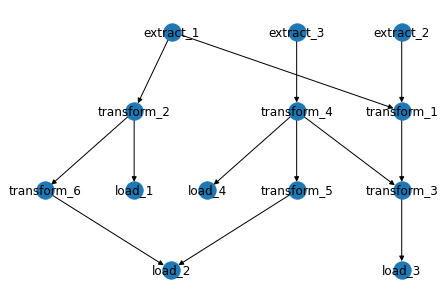

In [46]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels = True, arrows=True)
plt.show()

In [47]:
schedule_df['process'] = pd.Categorical(schedule_df['process'], list(nx.topological_sort(G)))
schedule_df = schedule_df.sort_values("process")
schedule_df

,process,dep_on,location,status,last_run
8,extract_1,NaN,scripts/extract_1.py,no status,never
0,extract_2,NaN,scripts/extract_2.py,no status,never
1,extract_3,NaN,scripts/extract_3.py,no status,never
3,transform_2,extract_1,scripts/transform_2.py,no status,never
2,transform_1,"extract_1,extract_2",scripts/transform_1.py,no status,never
5,transform_4,extract_3,scripts/transform_4.py,no status,never
7,transform_6,transform_2,scripts/transform_6.py,no status,never
9,load_1,transform_2,scripts/load_1.py,no status,never
4,transform_3,"transform_1,transform_4",scripts/transform_3.py,no status,never
6,transform_5,transform_4,scripts/transform_5.py,no status,never


In [48]:
from datetime import datetime

sdtout_list = []
stderr_list = []

for index, row in schedule_df.iterrows():

    print(schedule_df[['process', 'status']])

    if row['status'] == "no status":
        print("running ",row['process'], row['status'])
        result = subprocess.run([ "python", row['location']], capture_output=True)
        sdtout_list.append(result.stdout)
        stderr_list.append(result.stderr)

        if result.stderr == b'':
            schedule_df.at[index, 'status'] = 'success'
            schedule_df.at[index, 'last_run'] = datetime.date(datetime.now())
        else: 
            schedule_df.at[index, 'status'] = 'error'
            impacted_list = list(nx.dfs_tree(G, source=row['process']))
            impacted_list.remove(row['process'])
            schedule_df.loc[schedule_df['process'].isin(impacted_list), 'status'] = "dependency failed"
    else:
        pass
   

        process     status
8     extract_1  no status
0     extract_2  no status
1     extract_3  no status
3   transform_2  no status
2   transform_1  no status
5   transform_4  no status
7   transform_6  no status
9        load_1  no status
4   transform_3  no status
6   transform_5  no status
12       load_4  no status
11       load_3  no status
10       load_2  no status
running  extract_1 no status
        process             status
8     extract_1              error
0     extract_2          no status
1     extract_3          no status
3   transform_2  dependency failed
2   transform_1  dependency failed
5   transform_4          no status
7   transform_6  dependency failed
9        load_1  dependency failed
4   transform_3  dependency failed
6   transform_5          no status
12       load_4          no status
11       load_3  dependency failed
10       load_2  dependency failed
running  extract_2 no status
        process             status
8     extract_1              error
0   

In [7]:
colour_map = []

for index, row in schedule_df.iterrows():
    if row['status'] == 'no status':
        colour_map.append("grey")
    elif row['status'] == 'success':
        colour_map.append("green")
    elif row['status'] == 'error':
        colour_map.append("red")
    elif row['status'] == 'dependency failed':
        colour_map.append("blue")
    else:
        colour_map.append("pink")

colour_map

['red',
 'green',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red']

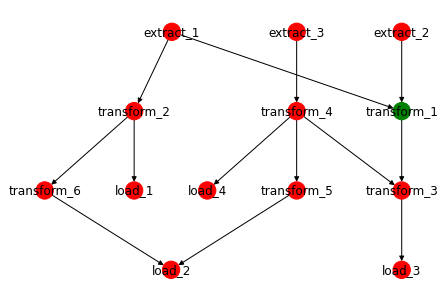

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels = True, arrows=True, node_color=colour_map)
plt.show()